In this notebook, we load transition matrices and perform basic computations, such as equilibrium values under different mutation model and response to a bottleneck.  


We first import packages and define plotting preferences. 

In [18]:
import numpy as np
import seaborn as sns
from indemmar import plot_and_legend
from pathlib import Path
from matplotlib import pyplot as plt
import numpy.linalg as la
import moments
import scipy
from subprocess import run
plt.style.use('seaborn')
plt.rc('font', family='serif', size=20)
plt.rc('xtick', labelsize=14) 

plt.rc('ytick', labelsize=14) 



The script to generate a Q matrix is written in C, and outputs the matrix to a file. 

We first define a function that attempts to read a matrix file and calls compute_Q_from_scratch.sh a shell script that generates the file if it doesn't already exist.  

In [19]:
data_store = Path.cwd() / Path("../data")

def read_Q(N, Ns, no, k, j):
    try:
        QT = np.loadtxt(data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"))
    except OSError:
        print("Q matrix",data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"), "was likely not found." 
          " Attempting to generate matrix " )
        run(["./compute_Q_from_scratch.sh",f"{N}", f"{Ns}", f"{no}", f"{k}", f"{j}"])
        QT = np.loadtxt(data_store / Path(f"q_mat_{N}_{Ns}_{no}_{k}_{j}.txt"))
    
    
    return QT.T # The matrix is stored in transposed format

Load matrices in large and small populations, for neutral and deleterious variants.

In [20]:
large_pop_size = 2000
small_pop_size = 200
sample_size = 200
s_del = 0.05
j = 7
k = 4

Q_small_neutral = read_Q(N=small_pop_size, Ns=0, no=sample_size, k=0, j=0)

Q_small_del = read_Q(N=small_pop_size, Ns=small_pop_size*s_del, no=sample_size, k=k, j=j)


Q_large_neutral = read_Q(N=large_pop_size, Ns=0, no=sample_size, k=0, j=0)

Q_large_del = read_Q(N=large_pop_size, Ns=large_pop_size*s_del, no=sample_size, k=k, j=j)

Test whether the columns of Q (and rows to QT) sum to 1. For the neutral model, this condition is usually met to machine precision. 

<Figure size 576x396 with 0 Axes>

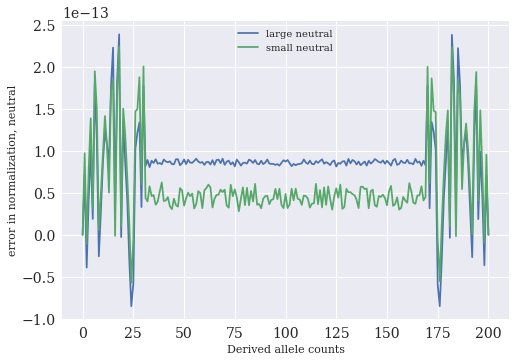

<Figure size 576x396 with 0 Axes>

In [21]:
plt.plot(Q_large_neutral.sum(axis=0)-1, label="large neutral")
plt.plot(Q_small_neutral.sum(axis=0)-1, label="small neutral")


plt.xlabel("Derived allele counts")
plt.ylabel("error in normalization, neutral")
plt.legend(loc="upper center")
plt.figure()



Repeat for the deleterious variation. 

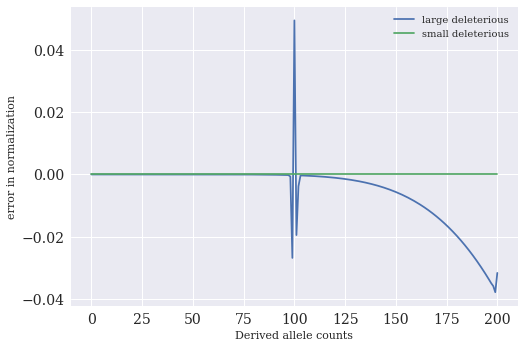

In [22]:
plt.plot(Q_large_del.sum(axis=0)-1, label="large deleterious")
plt.plot(Q_small_del.sum(axis=0)-1, label="small deleterious")

plt.legend(loc="upper right")
plt.xlabel("Derived allele counts")
plt.ylabel("error in normalization");

There can be a lack of normalization especially in the large_deleleterious matrix. This is not necessarily a problem: it is a quirk of the jackknife approach and is discussed in github issue #6. In short, The jackknife does not require normalization of probabilities for individual allele frequencies. Instead, it requires that transition matrices applied to a family of allele frequency distributions behave accurately. Since this family features only smooth distributions, such oscillations are allowed and do not affect smooth distributions of allele frequencies. However, they would affect predicted distributions conditioned on a fixed allele frequency.  

### Neutral steady-state in the infinite-sites model

To compute the steady-state distribution in the infinite-sites model, we can simply solve a linear equation equating the change in heterozygosity due to new mutations and to genetic drift. To provide a simple example contrasting the infinite-site and the finite-site models, we consider a sample of size 2 under neutrality. 

In [23]:
n_het=2  # sample size for heterozygosity
mu = 1e-8
predicted_pi = 2*mu*small_pop_size

Q_2_neutral = read_Q(N=small_pop_size, Ns=0, no=n_het, k=0, j=0)



# This code was copied and modified from Spectra.py in moments  
I = np.eye(n_het - 1)
z = np.zeros(n_het - 1)
z[0] = (n_het) * mu # z represents the constant supply of new mutations. 
pi = la.solve((Q_2_neutral[1:-1, 1:-1] - I), -z)

print("computed: pi", pi[0])
print("Expectation 2 N mu", predicted_pi)


computed: pi 3.9999999999999964e-06
Expectation 2 N mu 4e-06


### Neutral steady-state in the finite sites model

In the finite sites model, genetic drift is described by the same transition matrix Q_2_neutral. The influx of new mutations is now given by a transition matrix M rather than by a constant term $z$. Starting from the heterozygosity in the parents, we apply the matrix Q_2_neutral to obtain pairwise differences in the gametes prior to mutation, then the mutation matrix M to obtain the pairwise differences in the offspring after both mutation and drift. Thus the equilibrium distribution is obtained when parents and offspring have the same pairwise differences, and is measured after mutations are applied.  




In [24]:
# Load the reversible mutation matrix from moments
sparse_mutation = moments.LinearSystem_1D.calcB_FB(n_het+1,mu,mu)

# Add the identity matrix to obtain the recursion in the standard format
transition_mutation = sparse_mutation.toarray()+np.eye(n_het+1)

MQ = np.dot(transition_mutation, Q_2_neutral)

Here the solution can be obtained for the three possible configurations of a sample of size 2 (homozygote of both types and heterozygotes). Here we are looking for an eigenvector of matrix MQ with eigenvalue 1, or equivalently an eigenvector of matrix MQ-1 with eigenvalue 0.  

In [25]:
I3 = np.eye(n_het +1)
eigs = np.linalg.eig((MQ - I3))

#eig should be normalized to sum to 1
eigenvector = eigs[1][:,-1]/eigs[1][:,-1].sum()

print("eigenvector corresponding to eigenvalue", eigs[0][-1]," is\n", eigenvector)
print("computed: pi",  eigenvector[1])
print("Infinite-sites expectation 2 N mu", predicted_pi)


eigenvector corresponding to eigenvalue 1.0527687287457839e-17  is
 [4.99998000e-01 3.99996816e-06 4.99998000e-01]
computed: pi 3.999968160253552e-06
Infinite-sites expectation 2 N mu 4e-06


There are modest differences between the two models. For example, the creation of new heterozygotes in the finite sites model is slightly lower due to the fact that mutation only creates heterozygotes from fixed sites, of which there are $1-\pi$, whereas the infinite-sites model assumes a fixed rate of mutation.     

 ### Steady-state under selection in a larger sample
 
To model a bottleneck, we will use two matrices, corresponding to large ($N_L$) and bottlenecked ($N_B$) population sizes. We initialize the population with the steady-state for a large population. We will compare the steady-state for both large and small populations.
 
 

In [58]:
# Equilibrium spectrum for large vs small population, infinite-sites model

I = np.eye(sample_size - 1)
z_short = np.zeros(sample_size - 1)
z_short[0] = (sample_size) * mu
sfs_large_del = la.solve((Q_large_del[1:-1, 1:-1] - I), -z_short)
sfs_small_del = la.solve((Q_small_del[1:-1, 1:-1] - I), -z_short)

sfs_large_neutral = la.solve((Q_large_neutral[1:-1, 1:-1] - I), -z_short)
sfs_small_neutral = la.solve((Q_small_neutral[1:-1, 1:-1] - I), -z_short)

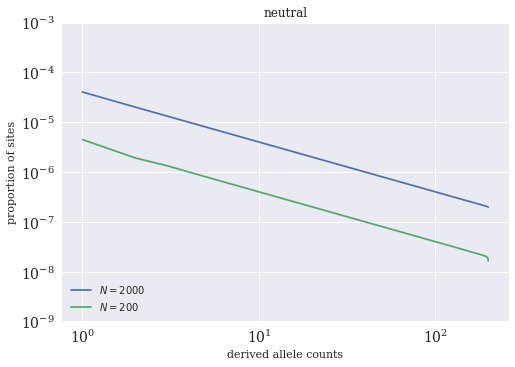

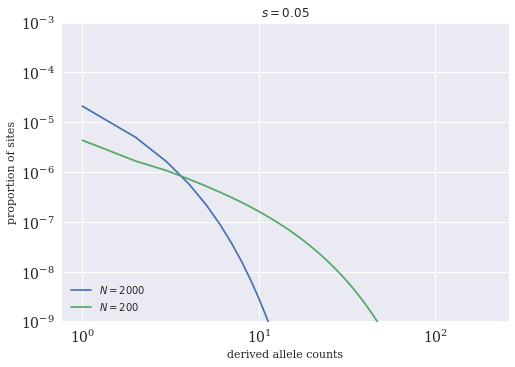

In [60]:

derived_allele_counts = np.arange(1, sample_size)
plt.loglog(derived_allele_counts, sfs_large_neutral,label = f'$N={large_pop_size}$')
plt.loglog(derived_allele_counts, sfs_small_neutral,label = f'$N={small_pop_size}$')
plt.legend(loc = "lower left")
plt.xlabel('derived allele counts')
plt.ylabel('proportion of sites')
plt.ylim([1e-9,1e-3])
plt.title("neutral");

plt.figure()

derived_allele_counts = np.arange(1, sample_size)
plt.loglog(derived_allele_counts, sfs_large_del,label = f'$N={large_pop_size}$')
plt.loglog(derived_allele_counts, sfs_small_del,label = f'$N={small_pop_size}$')
plt.legend(loc = "lower left")
plt.xlabel('derived allele counts')
plt.ylabel('proportion of sites')
plt.ylim([1e-9,1e-3])
plt.title(f'$s={s_del}$');



As expected, the large population shows a higher diversity under neutrality and a heavier skew towards rare variants reflecting the increase in the scaled selection coefficient $Ns$.


### Bottleneck in the infinite sites
Compute out-of-equilibrium SFS. Start from large population equilibrium, then apply small population transition matrix for n_generations. We will keep track of fixed sites during the bottleneck.  

In [61]:
n_generations = 10000
# We start with n_equilibrium_generations
n_equilibrium_generations = 20
list_sfs_WF = n_equilibrium_generations * [np.hstack((sfs_large,[0]))]  # Initialize list of AFS, add bin for fixed derived sites. 

z = np.zeros(sample_size)
z[0] = (sample_size) * mu
for _ in range(n_generations):
    list_sfs_WF.append(np.dot(Q_small_del[1:,1:],list_sfs_WF[-1]) + z)

A quick visualization of the AFS evolution. We only plot every 20 generations

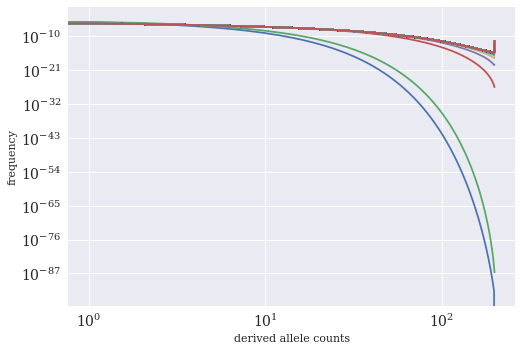

In [62]:
[plt.loglog(sfs) for sfs in list_sfs_WF[::20]];

plt.xlabel("derived allele counts")
plt.ylabel("frequency");



### Comparing to moments: transition matrices

To identify the effect of the multiple merger model, we would need a comparison with a transition model that is as similar as possible to the discrete transition matrix. Matrices defined in moments represent instantaneous rates of change for the AFS. To obtain transitions after a generation, we want the limit

$$\lim_{k\rightarrow \infty}(I+ (D+S)/k)^k = e^{D+S}$$ 

To facilitate comparison of genetic drift in the diffusion and Wright-Fisher models, we will treat mutations identically in both cases, that is, we'll assume here that mutations in both models are introduced once per generation, after drift and selection have been applied. 

In [66]:
h = 0.5

s_moments = 2*s_del # In moments, we are considering diploid selection 
                           # with the heterozygote aA having advantage h s = s/2 over aa. 
                           # To have relative advantage s_del, we must use s_moments = 2 s_del  
D_matrix_small = (1/2./small_pop_size) * moments.LinearSystem_1D.calcD(sample_size+1).toarray()
S_matrix =  s_moments * h * moments.LinearSystem_1D.calcS(sample_size+1, moments.Jackknife.calcJK13(sample_size))
moment_matrix_small_del = scipy.linalg.expm(D_matrix_small-S_matrix.toarray())


D_matrix_large = (1/2./large_pop_size) * moments.LinearSystem_1D.calcD(sample_size+1).toarray()
S_matrix = s_moments * h * moments.LinearSystem_1D.calcS(sample_size+1, moments.Jackknife.calcJK13(sample_size))
moment_matrix_large_del = scipy.linalg.expm(D_matrix_large-S_matrix.toarray())




moment_matrix_small_neutral = scipy.linalg.expm(D_matrix_small)
moment_matrix_large_neutral = scipy.linalg.expm(D_matrix_large)

<Figure size 576x396 with 0 Axes>

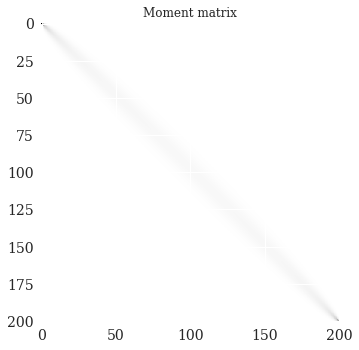

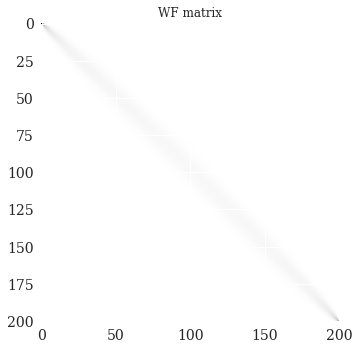

<Figure size 576x396 with 0 Axes>

In [65]:
plt.title("Moment matrix")
plt.imshow(moment_matrix_small_del)
plt.figure()
plt.title("WF matrix")
plt.imshow(Q_small_del)
plt.figure()


### Comparing to moments: equilibrium solutions

We first compute the equilibrium solutions under the moments transition matrix

In [67]:
moment_smallpop_equil_del = la.solve((moment_matrix_small_del[1:-1, 1:-1]-I), -z_short)
moment_largepop_equil_del = la.solve((moment_matrix_large_del[1:-1, 1:-1]-I), -z_short)

moment_smallpop_equil_neutral = la.solve((moment_matrix_small_neutral[1:-1, 1:-1]-I), -z_short)
moment_largepop_equil_neutral = la.solve((moment_matrix_large_neutral[1:-1, 1:-1]-I), -z_short)



Text(0.5, 1.0, 'large population')

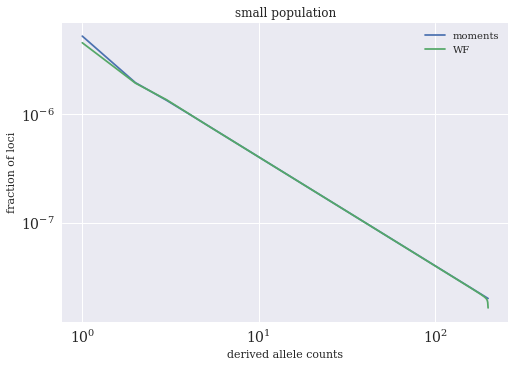

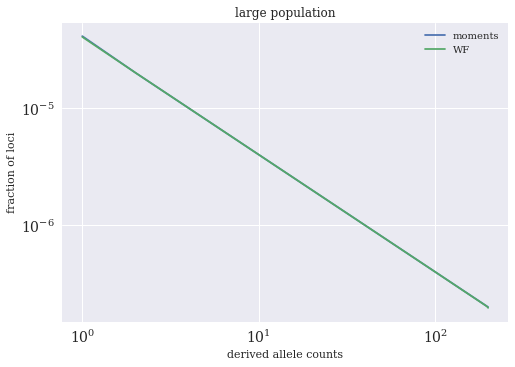

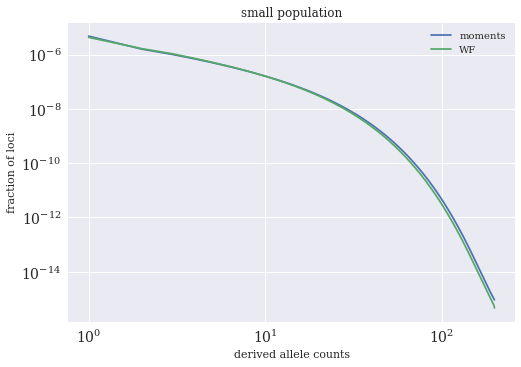

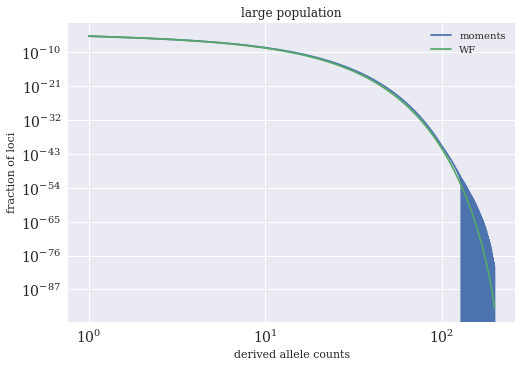

In [69]:
plt.loglog(derived_allele_counts, moment_smallpop_equil_neutral,label = "moments")
plt.loglog(derived_allele_counts, sfs_small_neutral,label = 'WF') #This sfs is from the WF model above
plt.legend(loc = "upper right")
plt.ylabel("fraction of loci")
plt.xlabel("derived allele counts")
plt.title("small population")

plt.figure()


plt.loglog(derived_allele_counts, moment_largepop_equil,label = "moments")
plt.loglog(derived_allele_counts, sfs_large_neutral,label = 'WF') #Thius sfs is from the WF model above
plt.legend(loc = "upper right")
plt.ylabel("fraction of loci")
plt.xlabel("derived allele counts")
plt.title("large population")


plt.figure()

plt.loglog(derived_allele_counts, moment_smallpop_equil_del,label = "moments")
plt.loglog(derived_allele_counts, sfs_small_del,label = 'WF') #Thius sfs is from the WF model above
plt.legend(loc = "upper right")
plt.ylabel("fraction of loci")
plt.xlabel("derived allele counts")
plt.title("small population")

plt.figure()


plt.loglog(derived_allele_counts, moment_largepop_equil_del,label = "moments")
plt.loglog(derived_allele_counts, sfs_large_del,label = 'WF') #Thius sfs is from the WF model above
plt.legend(loc = "upper right")
plt.ylabel("fraction of loci")
plt.xlabel("derived allele counts")
plt.title("large population")





The AFS are all qualitatively similar, as expected, so we will have to perform a more detailed comparison of relative errors. 

<Figure size 576x396 with 0 Axes>

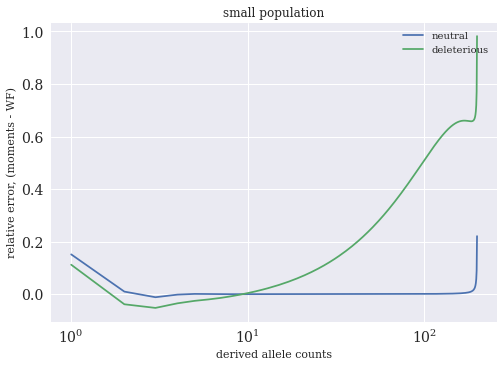

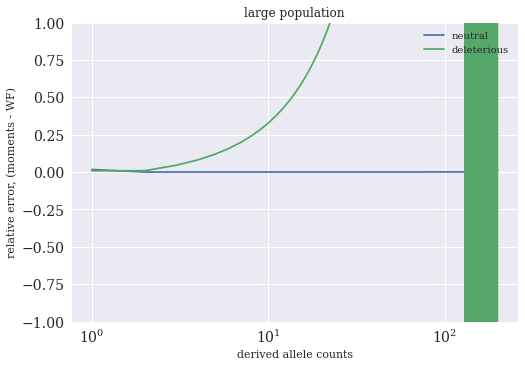

<Figure size 576x396 with 0 Axes>

In [78]:
plt.semilogx(derived_allele_counts, (moment_smallpop_equil_neutral-sfs_small_neutral)/sfs_small_neutral, label = "neutral")
plt.semilogx(derived_allele_counts, (moment_smallpop_equil_del-sfs_small_del)/sfs_small_del, label = "deleterious")


plt.legend(loc = "upper right")
plt.ylabel("relative error, (moments - WF)")
plt.xlabel("derived allele counts")
plt.title("small population")

plt.figure()


plt.semilogx(derived_allele_counts, (moment_largepop_equil_neutral-sfs_large_neutral)/sfs_large_neutral, label = "neutral")
plt.semilogx(derived_allele_counts, (moment_largepop_equil_del-sfs_large_del)/sfs_large_del, label = "deleterious")


plt.legend(loc = "upper right")
plt.ylabel("relative error, (moments - WF)")
plt.xlabel("derived allele counts")
plt.title("large population")
plt.ylim([-1,1])
plt.figure()

In both large ans small populations, we observe the biases for both common and rare variants, with an excess of common deleterious variants in moments. We also see some numerical instabilities for variants with over 100 derived counts. These are caused by the moment transition matrix, but is only relevant where a there is a vanishingly small number of sites.   

### Estimating the mutational load

load in diffusion 1.0811037423578268e-08
load in WF 1.0543996549846525e-08
relative excess load in diffusion 0.025326343049270998
Repeat for large population
load in diffusion 1.02999297748597e-08
load in WF 1.0049206047141781e-08
relative excess load in diffusion 0.0249496056247379


Text(0.5, 1.0, 'Large population')

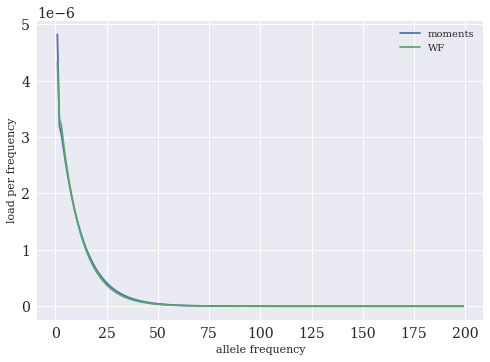

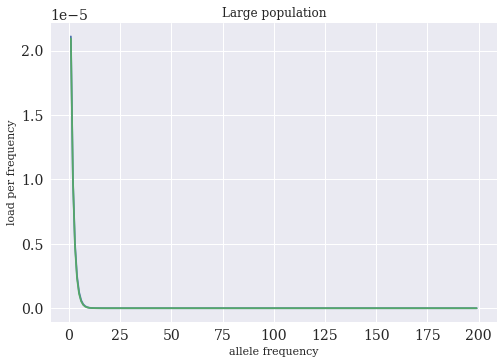

In [84]:
## Estimating load

diffusion_load = s_del*np.dot((np.arange(sample_size-1)+1)*1./sample_size, moment_smallpop_equil_del )
WF_load = s_del*np.dot((np.arange(sample_size-1)+1)*1./sample_size, sfs_small_del)
print("load in diffusion", diffusion_load)
print("load in WF", WF_load)

print("relative excess load in diffusion", (diffusion_load-WF_load)/WF_load)

plt.plot(np.arange(sample_size-1)+1, (np.arange(sample_size-1)+1)* moment_smallpop_equil_del,label="moments")
plt.plot(np.arange(sample_size-1)+1, (np.arange(sample_size-1)+1)* sfs_small_del, label = "WF")
plt.xlabel("allele frequency")
plt.ylabel("load per frequency");
plt.legend(loc = "upper right")

print("Repeat for large population")
plt.figure()

diffusion_load = s_del*np.dot(derived_allele_counts*1./sample_size, moment_largepop_equil_del)
WF_load = s_del*np.dot(derived_allele_counts*1./sample_size, sfs_large_del)
print("load in diffusion", diffusion_load)
print("load in WF", WF_load)

print("relative excess load in diffusion", (diffusion_load-WF_load)/WF_load)

plt.plot(derived_allele_counts, (np.arange(sample_size-1)+1)* moment_largepop_equil_del)
plt.plot(derived_allele_counts, (np.arange(sample_size-1)+1)* sfs_large_del)
plt.xlabel("allele frequency")
plt.ylabel("load per frequency");
plt.title("Large population")

Here again, there are modest differences of a few percent in the overall genetic load, and qualitative agreement between both models. We will agauin need to look at relative differences.  

(0.0, 10.0)

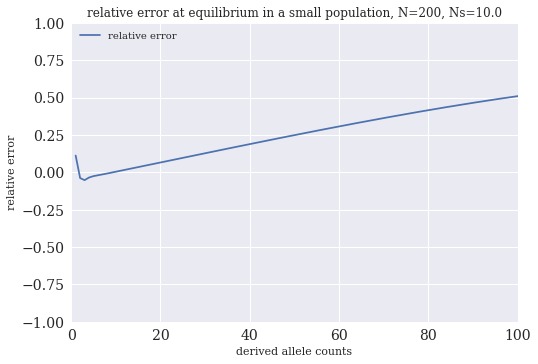

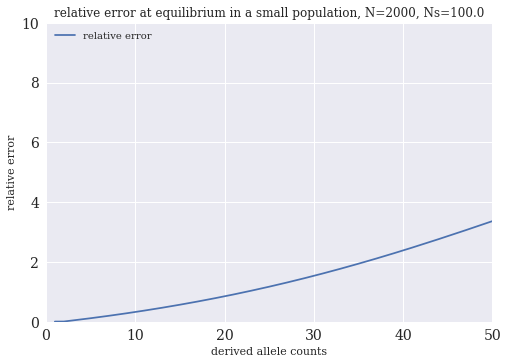

In [86]:
plt.plot(derived_allele_counts,(moment_smallpop_equil_del - sfs_small_del)/sfs_small_del ,label = "relative error")
plt.title(f"relative error at equilibrium in a small population, N={small_pop_size}, Ns={small_pop_size*s_del}")
plt.xlabel("derived allele counts")
plt.ylabel("relative error")
plt.legend(loc = "upper left")
plt.xlim([0,100])
plt.ylim([-1,1])

plt.figure()
plt.plot(derived_allele_counts,(moment_largepop_equil_del - sfs_large_del)/sfs_large_del ,label = "relative error")
plt.title(f"relative error at equilibrium in a small population, N={large_pop_size}, Ns={large_pop_size*s_del}")
plt.xlabel("derived allele counts")
plt.ylabel("relative error")
plt.legend(loc = "upper left")


plt.xlim([0,50])
plt.ylim([0,10])

There is substantial excess of load caused by common variants in moments, but this excess contributes only a tiny fraction of the overall genetic laod. 



We can now compare the out-of-equilibrium distributions. We simply run diffusion dynamics for the same number of generations starting from the same equilibrium AFS. 

In [39]:

list_sfs_moments = [list_sfs_WF[0]]


for _ in range(n_generations):
    list_sfs_moments.append(np.dot(moment_matrix_small_del[1:,1:],list_sfs_moments[-1]) + z)

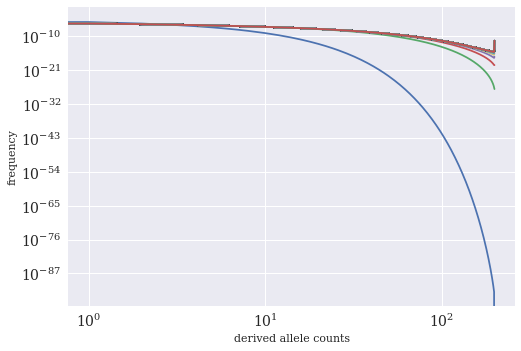

In [40]:
[plt.loglog(sfs) for sfs in list_sfs_moments[::20]];

plt.xlabel("derived allele counts")
plt.ylabel("frequency");



Text(0, 0.5, 'frequency')

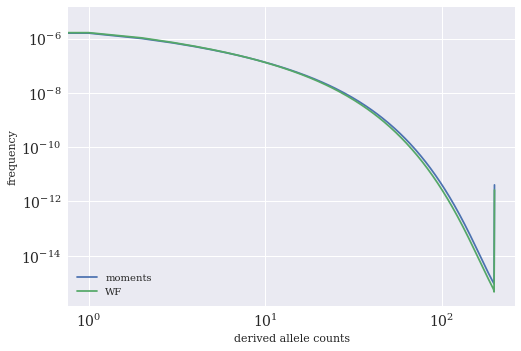

In [41]:
compare_generation = len(list_sfs_moments)-1

plt.loglog(list_sfs_moments[compare_generation],label = "moments")
plt.loglog(list_sfs_WF[compare_generation],label = "WF")
plt.legend(loc="lower left")

plt.xlabel("derived allele counts")
plt.ylabel("frequency")


relative error in (n-1)-tons

In [42]:
array_moments = np.array(list_sfs_moments)
array_WF = np.array(list_sfs_WF)

(0.0, 1e-07)

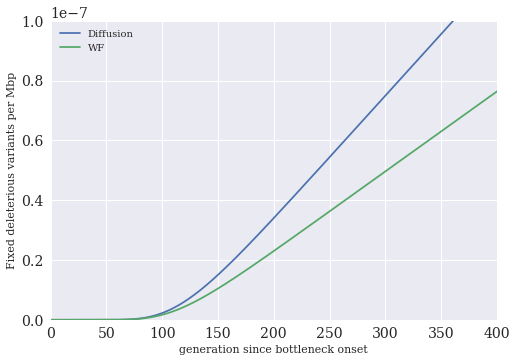

In [43]:
frequency_bin_to_plot = -1

plt.plot(10**6*array_moments[:,frequency_bin_to_plot], label = "Diffusion")
plt.plot(10**6*array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation since bottleneck onset")
plt.ylabel("Fixed deleterious variants per Mbp")
plt.legend(loc="upper left")
plt.xlim( [0,400])
plt.ylim( [0,1e-7])
#plt.title("fixation following a bottleneck");


In [44]:
# Show the polymorphic load vs 

(0.0, 10.0)

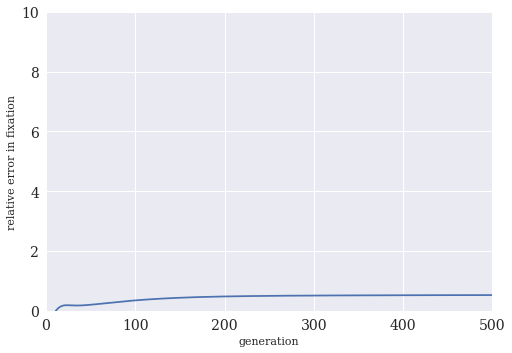

In [45]:
frequency_bin_to_plot = -1
plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/array_WF[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error in fixation")
plt.xlim((0,500))
plt.ylim((0,10))

(0.0, 200.0)

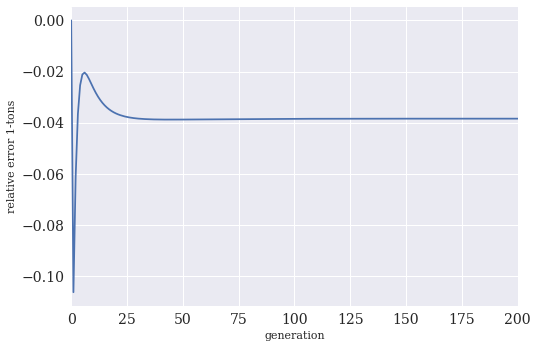

In [46]:
frequency_bin_to_plot = 1
plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/array_WF[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error 1-tons")
plt.xlim((0,200))

Repeat for neutrality

In [98]:
n_generations = 1000
list_sfs_WF_neutral = [np.hstack((sfs_large_neutral,[0]))]  # Consider fixed mutations as well as polymorphisms 

for _ in range(n_generations):
    list_sfs_WF_neutral.append(np.dot(QT_bottle_neutral.transpose()[1:,1:],list_sfs_WF_neutral[-1]) + z)

NameError: name 'sfs_large_neutral' is not defined

In [ ]:
[plt.loglog(sfs) for sfs in list_sfs_WF_neutral[:100]];

In [ ]:
moment_matrix_neutral = scipy.linalg.expm(D_matrix)



In [ ]:
n_generations = 1000
list_sfs_moments_neutral = [list_sfs_WF_neutral[0]]

for _ in range(n_generations):
    list_sfs_moments_neutral.append(np.dot(moment_matrix_neutral[1:,1:],list_sfs_moments_neutral[-1]) + z)

In [ ]:
array_moments_neutral = np.array(list_sfs_moments_neutral)
array_WF_neutral = np.array(list_sfs_WF_neutral)

In [ ]:
frequency_bin_to_plot = -1

plt.plot(array_moments_neutral[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF_neutral[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")

plt.legend(loc = "upper right")


In [ ]:
frequency_bin_to_plot = -1
plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])/array_WF_neutral[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error (n-1)-tons")
plt.xlim((0,200))


In [ ]:
frequency_bin_to_plot = 1

plt.plot(array_moments_neutral[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF_neutral[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")

In [ ]:
frequency_bin_to_plot = 1
plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])/array_WF_neutral[:,frequency_bin_to_plot], label = "moments")
plt.xlabel("generation")
plt.ylabel("relative error (n-1)-tons")
plt.xlim((0,200))

In [ ]:
frequency_bin_to_plot = 1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral, singletons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])
         /array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious, singletons")

frequency_bin_to_plot = -1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral $(n-1)$-tons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/
         array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious $(n-1)$-tons")


plt.xlim((0,200))
plt.legend(loc="upper left")
plt.ylabel("Relative error")
plt.xlabel("Generation after bottleneck")

There is something happening extraordinarily fast, specifically for the $n-1$-tons. LEt us look at this in case it is just a bug. 

In [ ]:
frequency_bin_to_plot = 1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral, singletons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])
         /array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious, singletons")

frequency_bin_to_plot = -1

plt.plot((array_moments_neutral[:,frequency_bin_to_plot]-array_WF_neutral[:,frequency_bin_to_plot])
         /array_WF_neutral[:,frequency_bin_to_plot], label="Neutral $(n-1)$-tons")

plt.plot((array_moments[:,frequency_bin_to_plot]-array_WF[:,frequency_bin_to_plot])/
         array_WF[:,frequency_bin_to_plot], lw=3, label="Deleterious $(n-1)$-tons")


plt.xlim((0,30))
plt.legend(loc="upper left")
plt.ylabel("Relative error")
plt.xlabel("Generation after bottleneck")

In [ ]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,500))




So if there is not problem, what is going on is that the rate of fixation is higher, overall, and more specifically that the fixation starts quite a bit earlier. 

In [ ]:
frequency_bin_to_plot = -1

plt.plot(array_moments[:,frequency_bin_to_plot], label = "moments")
plt.plot(array_WF[:,frequency_bin_to_plot], label = "WF")
plt.xlabel("generation")
plt.ylabel("proportion of (n-1)-tons")
plt.legend(loc="center right")
plt.xlim((0,200))

